In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches



In [2]:
df = pd.read_csv('data/raw/new_retail_data.csv')

---
---

# CLEANING

In [3]:
df_clean = df[['Transaction_ID','Customer_ID','Date','Total_Amount']].dropna()

In [4]:
df_clean['Transaction_ID'] = df_clean['Transaction_ID'].astype(int)
df_clean['Customer_ID'] = df_clean['Customer_ID'].astype(int)

In [5]:
df_clean['Date'] = df_clean['Date'].apply( lambda x: datetime.strptime(x, "%m/%d/%Y").strftime("%Y/%m/%d") )

---
---

# RFM COMPUTATION

In [6]:
analysis_date = df_clean['Date'].max()

print(f"the date chosen for this anaysis is {analysis_date}.")

analysis_date = pd.Timestamp(analysis_date)

the date chosen for this anaysis is 2024/02/29.


In [7]:
df_customer_date = df_clean.groupby('Customer_ID')['Date'].max().reset_index()
df_customer_date = df_customer_date.rename({'Date':'Last_Purchase_Date'},axis=1)
df_customer_date['Last_Purchase_Date'] = pd.to_datetime(df_customer_date['Last_Purchase_Date'])


In [8]:
df_customer_date['Recency'] = analysis_date - df_customer_date['Last_Purchase_Date']

In [9]:
df_customer_freq = df_clean.groupby('Customer_ID')['Transaction_ID'].count().reset_index()
df_customer_freq = df_customer_freq.rename({'Transaction_ID':'Frequency'},axis=1)

In [10]:
df_customer_mntr = df_clean.groupby('Customer_ID')['Total_Amount'].mean().reset_index()
df_customer_mntr = df_customer_mntr.rename({'Total_Amount':'Monetary'},axis=1)

In [11]:
df_customer = df_customer_date.merge(df_customer_freq,on='Customer_ID')
df_customer = df_customer.merge(df_customer_mntr,on='Customer_ID')

In [12]:
df_customer['Recency'] = df_customer['Recency'].dt.days

In [13]:
df_customer['Recency_Score'] = pd.qcut(df_customer['Recency'], q=4, labels=[1, 2, 3, 4]).astype(int)
df_customer['Frequency_Score'] = pd.qcut(df_customer['Frequency'], q=4, labels=[1, 2, 3, 4]).astype(int)
df_customer['Monetary_Score'] = pd.qcut(df_customer['Monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)

In [14]:
df_customer['RFM_Score'] = df_customer['Recency_Score']*100 + df_customer['Frequency_Score']*10 + df_customer['Monetary']

---

VISUALIZE THE RESULTS

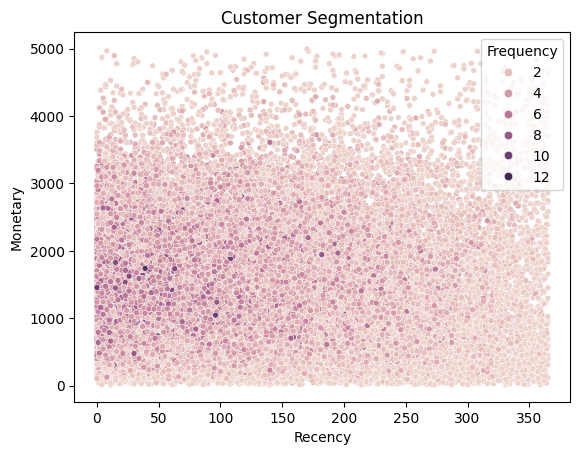

In [15]:
sns.scatterplot(data=df_customer, x='Recency', y='Monetary', hue='Frequency',size=5, legend="brief")
plt.title('Customer Segmentation')

handles, labels = plt.gca().get_legend_handles_labels()
new_handles_labels = [(h, l) for h, l in zip(handles, labels) if l != "5"]
plt.legend(*zip(*new_handles_labels), title="Frequency")

plt.savefig('artifacts/imgs/RFM_distribution.png', transparent=True)
plt.show()

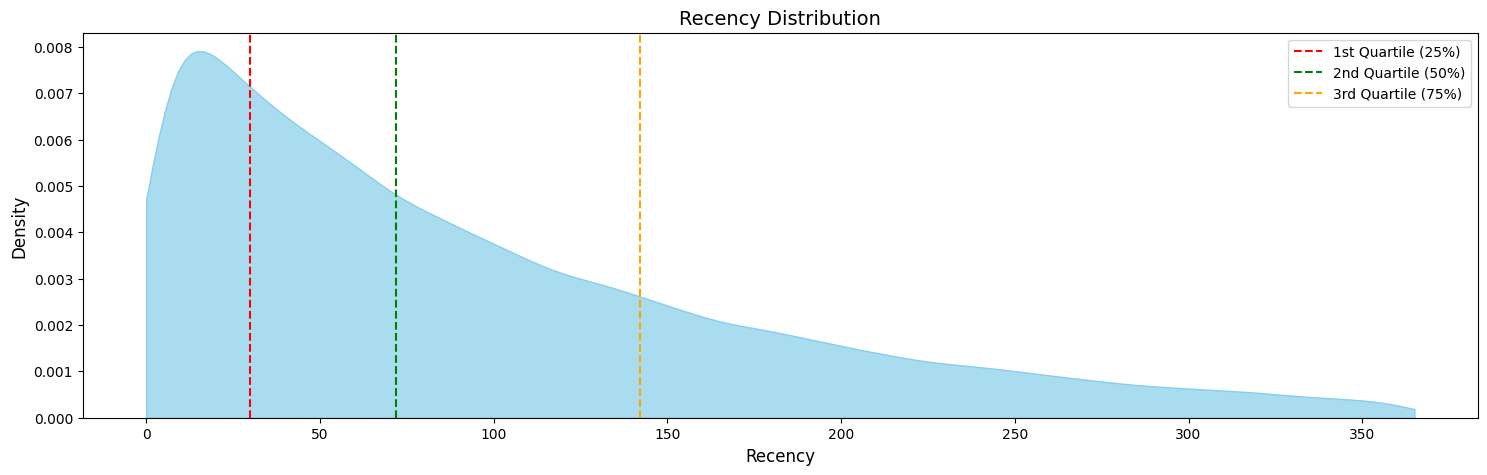

In [16]:
plt.figure(figsize=(18, 5))

quartiles = df_customer['Recency'].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df_customer['Recency'].astype(int), fill=True, color="skyblue", alpha=0.7,cut=0)

plt.axvline(quartiles[0.25], color='red', linestyle='--', label='1st Quartile (25%)')
plt.axvline(quartiles[0.5], color='green', linestyle='--', label='2nd Quartile (50%)')
plt.axvline(quartiles[0.75], color='orange', linestyle='--', label='3rd Quartile (75%)')

plt.legend()

plt.title('Recency Distribution', fontsize=14)
plt.xlabel('Recency', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.savefig('artifacts/imgs/Recency.png', transparent=True)
plt.show()


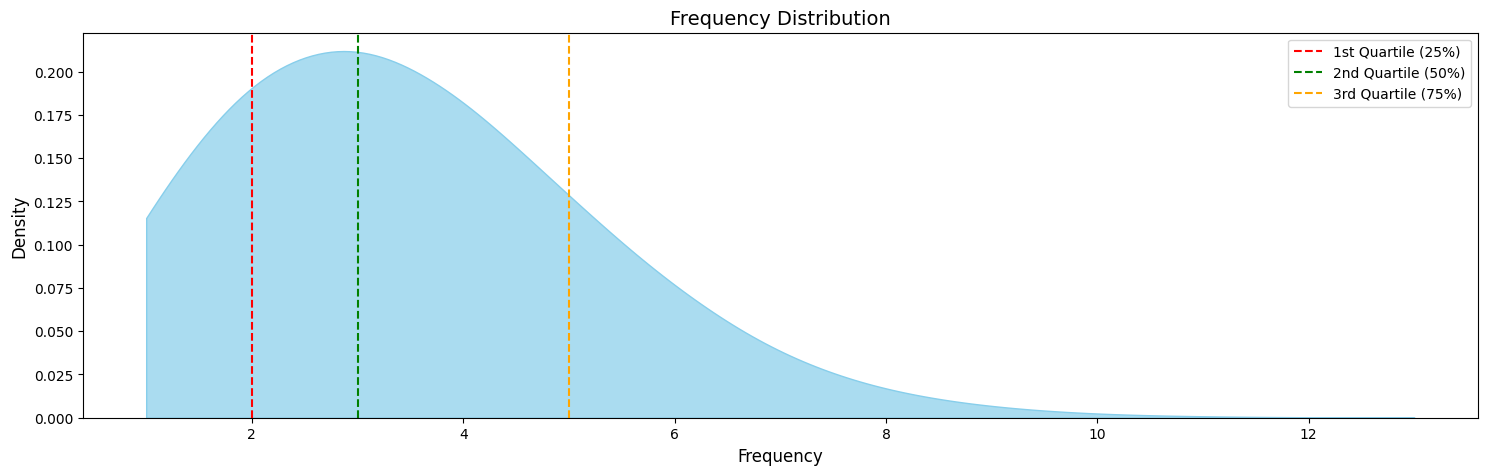

In [17]:
plt.figure(figsize=(18, 5))

quartiles = df_customer['Frequency'].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df_customer['Frequency'].astype(int), fill=True, color="skyblue", alpha=0.7,bw_method=0.4,cut=0)

plt.axvline(quartiles[0.25], color='red', linestyle='--', label='1st Quartile (25%)')
plt.axvline(quartiles[0.5], color='green', linestyle='--', label='2nd Quartile (50%)')
plt.axvline(quartiles[0.75], color='orange', linestyle='--', label='3rd Quartile (75%)')

plt.legend()

plt.title('Frequency Distribution', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.savefig('artifacts/imgs/Frequency.png', transparent=True)
plt.show()


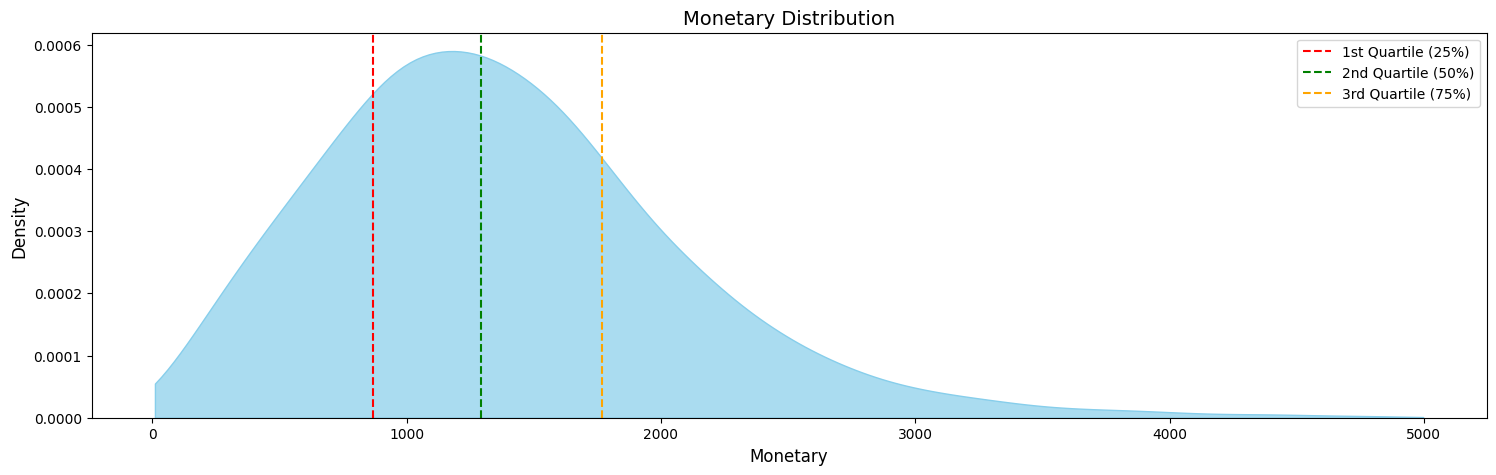

In [18]:
plt.figure(figsize=(18, 5))

quartiles = df_customer['Monetary'].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df_customer['Monetary'], fill=True, color="skyblue", alpha=0.7,bw_method=0.2,cut=0)

plt.axvline(quartiles[0.25], color='red', linestyle='--', label='1st Quartile (25%)')
plt.axvline(quartiles[0.5], color='green', linestyle='--', label='2nd Quartile (50%)')
plt.axvline(quartiles[0.75], color='orange', linestyle='--', label='3rd Quartile (75%)')

plt.legend()

plt.title('Monetary Distribution', fontsize=14)
plt.xlabel('Monetary', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.savefig('artifacts/imgs/Monetary.png', transparent=True)
plt.show()


---
---

# DIVIDING INTO SEGMENTS

* Champions (High R, F, M): Frequent, high-value, recent buyers.
* Promising (High R): has bought recently, could become more engaged. 
* Loyal Customers (High F): Regular buyers, not necessarily recent.
* Big Spenders (High M): High monetary value, but less frequent.
* At Risk (Low R): Haven’t purchased recently but had high past value.
* Lost Customers (Low R, F, M): Inactive or disengaged customers.


In [19]:
def RFM_segmentation(row):

    if row['Recency_Score'] > 2:
        if row['Frequency_Score'] > 2 and row['Monetary_Score'] > 2:
            return "Champion"
        elif row['Frequency_Score'] > 2 and row['Monetary_Score'] <= 2:
            return "Loyal"
        elif row['Frequency_Score'] <= 2 and row['Monetary_Score'] > 2:
            return "Big Spender"
        else:
            return "Promising"
    else:
        if row['Frequency_Score'] > 2 or row['Monetary_Score'] > 2:
            return 'At Risk'
        else:
            return 'Lost'

In [20]:
df_customer['RFM_label'] = df_customer.apply(RFM_segmentation,axis=1)

---

### VISUALIZE THE RESULTS

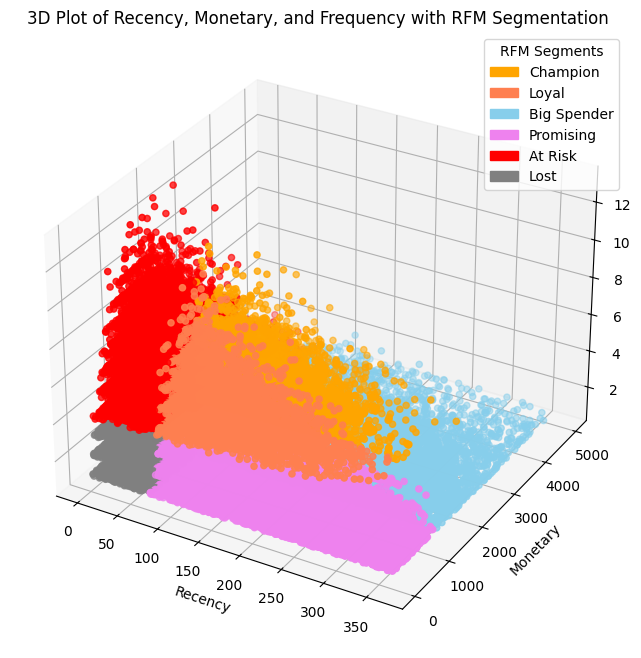

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

color_map = {'Champion': 'orange', 
             'Loyal': 'coral', 
             'Big Spender': 'skyblue', 
             'Promising': 'violet', 
             'At Risk': 'red',
             'Lost': 'gray'}


# Scatter plot with color based on RFM_label
sc = ax.scatter(df_customer['Recency'], 
                df_customer['Monetary'], 
                df_customer['Frequency'], 
                c=df_customer['RFM_label'].map(color_map), 
                s=20, marker='o')

# Add labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
ax.set_title('3D Plot of Recency, Monetary, and Frequency with RFM Segmentation')

# Create a legend
handles = [mpatches.Patch(color=color_map[label], label=label) for label in color_map]
ax.legend(handles=handles, title="RFM Segments")

# Show the plot

plt.savefig('artifacts/imgs/RFM_segments.png', transparent=True)

plt.show()
